<center><font color="darkred"><h1 id="header">Cats vs Dogs: Transfer Learning approach</h1></font></center>

Let's try to distinguish dogs from cats! We will try to apply Transfer Learning using [VGG16 from the keras library](https://keras.io/applications/#vgg16).

In [1]:
import os
%matplotlib inline

from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [3]:
# defining the dimensions of the images
input_shape =  (224, 224)

# defining the batch-size of the parameters
batch_size = 64

train_data_dir = './dogscats/train'
validation_data_dir = './dogscats/valid'

# Visualize some data

In [4]:
def plot_examples(path):
    print('Images belonging to class:', path)
    listdir = os.listdir(path)
    fig, ax = plt.subplots(nrows=2,ncols=5,figsize=(20,10))
    ax = ax.ravel()
    for idx, e in enumerate(listdir[:10]):
        img = imread(os.path.join(path, e))
        img = imresize(img,input_shape)
        ax[idx].imshow(img)

Images belonging to class: ./dogscats/train/cats


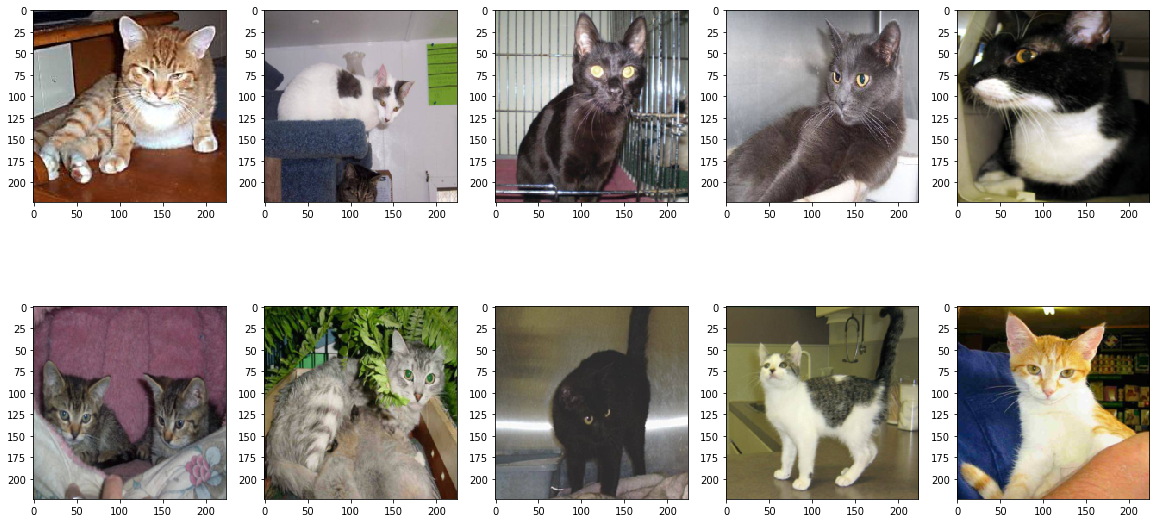

In [5]:
plot_examples('./dogscats/train/cats')

Images belonging to class: ./dogscats/train/dogs


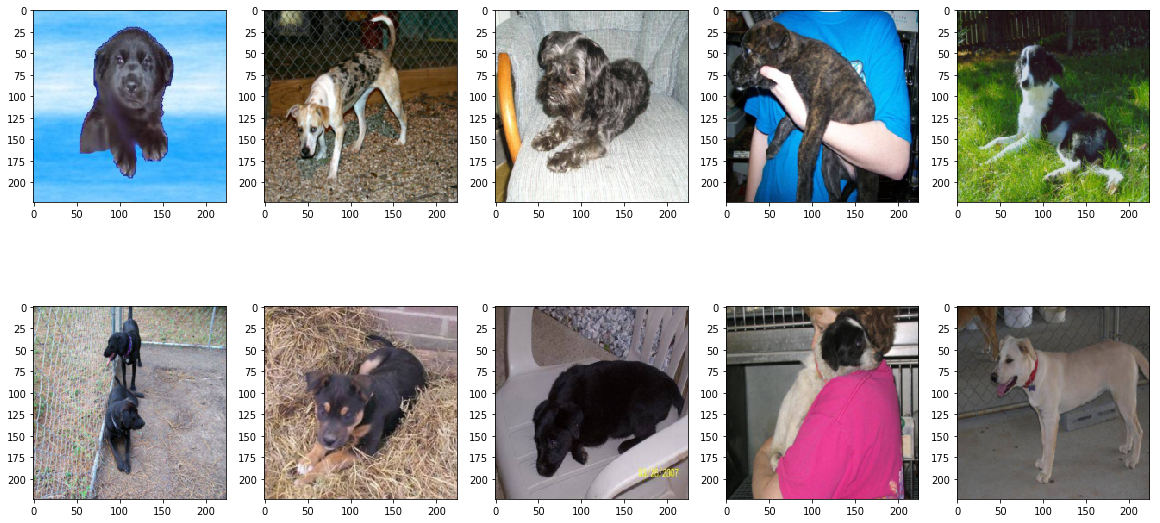

In [6]:
plot_examples('./dogscats/train/dogs')

# Preparing DataGenerator

In [7]:
datagen = ImageDataGenerator()

datagen_augmented = ImageDataGenerator(
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        rotation_range=20,     # ranndomly rotates images
        width_shift_range=0.2, # randomly shifts the image (width wise)
        height_shift_range=0.2,# randomly shifts the image (height wise)
        horizontal_flip=True,  # randomly flip the images (horizentally) 
        vertical_flip=True)    # randomly flip the images (vertically)

In [8]:
def get_batches(generator, path, class_mode='categorical', batch_size=32, input_shape=(224,224),shuffle=False):
    '''Getting batches by flowing from directory
    Parameters:
    ---------------
    generator: Keras object
        The Image Data Generator Correctly filled
        
    path: str
        The path to train, val or test directory containing at least one class.
        Reminder: classes are organized in sub-folders
    
    class_mode: str, optional (default='categorical')
        Indicate the class mode of the data generator, if 'binary' or 'categorical'
    
    batch_size: int, optional (default=32)
        The size of each batch
    
    input_shape: tuple, optional (default=(224, 224))
        The size  to which the inputs need to be sized.
        Resizing done automatically if necessary.
    
    shuffle: boolean, optional (default=False)
        Wether to shuffle or not when getting batches
        
    Output:
    ---------------
    batches: Keras object
        The batches of images found by the ImageGenerator
    '''
    batches = generator.flow_from_directory(path,
                                            target_size=input_shape,
                                            batch_size=batch_size,
                                            class_mode=class_mode,
                                            shuffle=shuffle)
    return(batches)

In [9]:
# applying Data-Augmentation for train images
train_gen = get_batches(datagen,
                        train_data_dir,
                        class_mode='binary',
                        batch_size=batch_size,
                        shuffle=False)

# Simply Rescaling validation images
valid_gen = get_batches(datagen,
                        validation_data_dir,
                        class_mode='binary',
                        batch_size=batch_size,
                        shuffle=False)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Transfer Learning step-by-step ...

### step 1 - Getting convo layers from a pre-trained CNN

In [10]:
def get_VGG16(trainable=False,
              pop=True):
    '''It calls the convolutional part of the vgg model. 
    The model will mainly serve as feature extractor from the images
    Parameters:
    -------------
    trainable: Boolean, optional (default=False) 
        If to train the convolutional layers or not
        
    pop: Boolean, optional (default=True)
        if to pop the Maxpooling layer of not
    
    Output:
    -------------
    model: Keras Sequential model 
        The full model, compiled, ready to be fit.
    '''
    
    #importing convolutional layers of vgg16 from keras
    model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
    if pop == True:
        model = Sequential(model.layers[:-1])
    #setting the convolutional layers to non-trainable 
    for layer in model.layers:
        layer.trainable = trainable
    return(model)

In [11]:
vgg_conv = get_VGG16()
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### step 2 - Forward pass

In [14]:
%%time
train_bottleneck_features = vgg_conv.predict_generator(generator=train_gen, steps=train_gen.n//batch_size, verbose=1)
valid_bottleneck_features = vgg_conv.predict_generator(generator=valid_gen, steps=valid_gen.n//batch_size, verbose=1)

31/31 [==============================] - 31s    
CPU times: user 8min 1s, sys: 27.1 s, total: 8min 29s
Wall time: 6min 48s


##### Save or load botteleneck features

Save ...

In [18]:
np.save(open('./dogscats/train_bottleneck.npy', 'wb'), train_bottleneck_features)
np.save(open('./dogscats/valid_bottleneck.npy', 'wb'), valid_bottleneck_features)

load ....

In [12]:
train_bottleneck_features = np.load(open('./dogscats/train_bottleneck.npy', 'rb'))
valid_bottleneck_features = np.load(open('./dogscats/valid_bottleneck.npy', 'rb'))

#### Get Onehot encoded labels

In [13]:
y_train = np_utils.to_categorical(train_gen.classes)
y_valid = np_utils.to_categorical(valid_gen.classes)

y_train = np.array([i[0] for i in y_train])
y_valid = np.array([i[0] for i in y_valid])

### step 3 - Re-building top part of the model for training

In [14]:
def top_model_vgg(n_classes,
                  X_shape,
                  dense_neurons=512,
                  do=0.5, 
                  loss_function = 'categorical_crossentropy',
                  output_activation='softmax',
                  optimizer='adam'):
    """ Top model multi:MLP 
    The top model corresponds to the VGG16's classification layers.
    The model is adapted for MULTICLASS classification tasks.
    
    Parameters:
    -------------
    n_classes: int 
        How many classes are you trying to classify ? 
        
    X_shape: tuple, optional (default=(7,7,512))
        The input shape for the first layer.
    
    dense_neurons: int, optional (default=512)
        The number of neurons in the hidden dense layers
        
    do: float, optional (default=0.5) 
        Dropout probability
    
    loss_function: str, optional (default='categorical_crossentropy')
        The loss function (keras object)
        
    output_activation: str, optional(default='softmax')
        The output activation layer
    
    optimizer: str or keras object, optional (default='adam')
        The optimizer of your choice.
        
    Output:
    -------------
    model: Keras Sequential model 
        The full model, compiled, ready to be fit.
    """
    
    ### top_model takes output from VGG conv and then adds 2 hidden layers
    top_model = Sequential()
    top_model.add(MaxPooling2D(input_shape=X_shape,name = 'top_maxpooling'))
    
    top_model.add(BatchNormalization())
    
    top_model.add(Flatten(name='top_flatten'))
    top_model.add(Dense(dense_neurons, activation='relu', name='top_relu_1'))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(do))
    
    top_model.add(Dense(dense_neurons, activation='relu', name='top_relu_2'))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(do))
    
    ### the last multilabel layers with the number of classes
    top_model.add(Dense(n_classes, activation=output_activation))
    
    top_model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
    
    return(top_model)

In [15]:
# choosing your optimizer
adam = keras.optimizers.Adam(lr=0.001)
rmsprop = keras.optimizers.RMSprop(lr=0.01)

# building model
model = top_model_vgg(X_shape=(14,14,512),
                      dense_neurons=512,
                      do=0.75,
                      optimizer=adam,
                      n_classes=1,
                      loss_function='binary_crossentropy',
                      output_activation='sigmoid')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
top_maxpooling (MaxPooling2D (None, 7, 7, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
top_flatten (Flatten)        (None, 25088)             0         
_________________________________________________________________
top_relu_1 (Dense)           (None, 512)               12845568  
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
top_relu_2 (Dense)           (None, 512)               262656    
__________

### step 4 - Fitting the top model

In [16]:
model.fit(train_bottleneck_features[:len(train_bottleneck_features)], y_train[:len(train_bottleneck_features)],
          epochs=4,
          batch_size=64,
          validation_data=(valid_bottleneck_features[:len(valid_bottleneck_features)],y_valid[:len(valid_bottleneck_features)]))

Train on 22976 samples, validate on 1984 samples
Epoch 1/4
22976/22976 [==============================] - 14s - loss: 0.1812 - acc: 0.9362 - val_loss: 0.0794 - val_acc: 0.9688
Epoch 2/4
22976/22976 [==============================] - 12s - loss: 0.0929 - acc: 0.9651 - val_loss: 0.0831 - val_acc: 0.9713
Epoch 3/4
22976/22976 [==============================] - 12s - loss: 0.0631 - acc: 0.9762 - val_loss: 0.0760 - val_acc: 0.9713
Epoch 4/4
22976/22976 [==============================] - 12s - loss: 0.0511 - acc: 0.9808 - val_loss: 0.0830 - val_acc: 0.9688


##  Visual checking

In [17]:
preds = model.predict(valid_bottleneck_features)

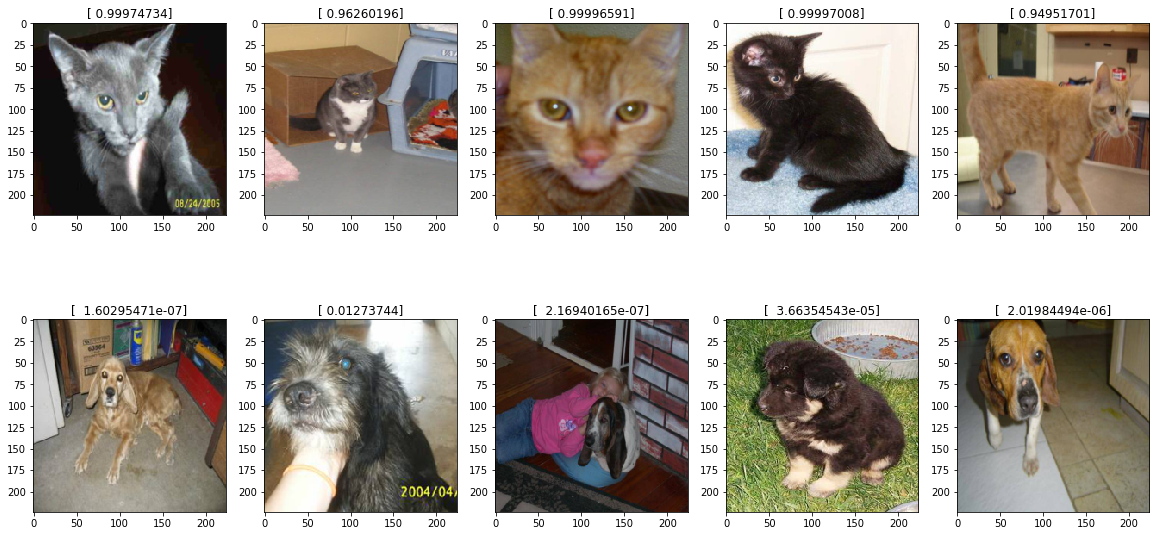

In [18]:
path = './dogscats/valid'
fig, ax = plt.subplots(nrows=2,ncols=5,figsize=(20,10))
ax = ax.ravel()

listdir = valid_gen.filenames[:5] + valid_gen.filenames[-5:]
preds_ex = np.concatenate((preds[:5],preds[-5:]))

for idx, e in enumerate(listdir):
    img = imread(os.path.join(path, e))
    img = imresize(img,input_shape)
    ax[idx].imshow(img)
    ax[idx].set_title(preds_ex[idx])